# Imports

In [86]:
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload
from common.baseclasses import AWA

from NearFieldOptics import Materials as M
import EigenProbe as EP
TM=EP #legacy naming support

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# Set up the problem

## Define homogeneous space and homogeneous conductivity to use

In [90]:
#--- Sizes for the simulation
N=300
L=200 #We will deal in units of tip radius, so this will be a 6 micron (or so) view
Nq=3000

#--- Build homogeneous graphene with appropriate dimensions
Graphene=TM.S.SpectralLaplacian_uniform(Lx=L,Nx=N,Ly=L,Nqmax=Nq)
X,Y=Graphene.XY
dx=np.diff(Graphene.xy[0])[0]

#--- Define plasmon wavelength to set scale of 2D conductivities
#LambdaP=TM.S.Constant(20)

#Substrate=TM.SubstrateDielectric(beta=0.5,base_laplacian=Graphene) #Inherit basis from graphene

Generating eigenpairs on x,y=[-100.0:+100.0:300],[-100.0:+100.0:300]
	Time elapsed: 5.469474792480469


## Define hBN substrate

hBN polariton wavelength (simulation units): 18.81441146320868


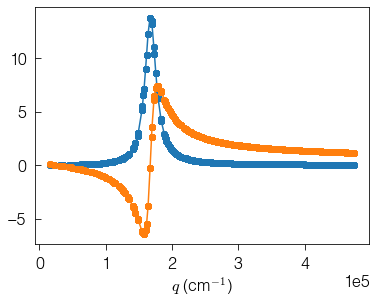

In [91]:
freq=1485
layers=M.LayeredMediaTM((M.BN_Caldwell,40e-7),exit=M.SiO2_300nm)

length_unit=20e-7 #Size of a pixel in cm --> 20e-7 = 20 nm
Substrate=TM.SubstrateFromLayers(layers,length_unit,freq=freq,\
                                 base_laplacian=Graphene) #Inherit q-values & planewave basis from graphene

plt.figure()
np.imag(Substrate.rp).plot(marker='o')
np.real(Substrate.rp).plot(marker='o')

qs=Substrate.rp.axes[0]
print('hBN polariton wavelength (simulation units):',\
       2*np.pi/qs[np.argmax(Substrate.rp.imag)]/length_unit)

## Add domain wall conductivity

Text(0.5, 1.0, 'Added conductivity')

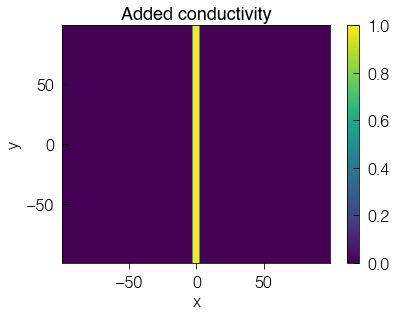

In [76]:
#--- Build inhomogeneous conductivity
width=5
dsigma_profile=(np.abs(X)<width/2) #ribbon

Defect_xx=TM.S.GridLaplacian_aperiodic(dx,sigma_xx=dsigma_profile,sigma_yy=0) #`sigma` plays role of conductivity
Defect_yy=TM.S.GridLaplacian_aperiodic(dx,sigma_yy=dsigma_profile,sigma_xx=0) #`sigma` plays role of conductivity
#GL=0 #in case we want to turn it off

plt.figure()
AWA(dsigma_profile,adopt_axes_from=Graphene.AWA).real.plot()
plt.title('Added conductivity')

## Construct Green's function to define our problem

In [93]:
Q=10 #Quality factor of graphene plasmons
PS=TM.Photonic2DSystem(Substrate,(Graphene,Defect_xx,Defect_yy),
                       lambdap=20,sigmas2D=[1-1j/Q]*3,PML_amplitude=1,\
                       basis=Substrate,Nbasis=Nq)

Projecting operator 1 onto basis...
Projecting operator 2 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 45.298547983169556
Building 2876x2876 inner product matrix...
	Time elapsed: 28.335498094558716
Projecting operator 3 onto basis...
Building 2876x2876 inner product matrix...
	Time elapsed: 6.413926124572754
Projecting operator 4 onto basis...
Projecting operator 5 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 15.053977012634277
Building 2876x2876 inner product matrix...
	Time elapsed: 6.269601106643677
Projecting operator 6 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 15.133495807647705
Building 2876x2876 inner product matrix...
	Time elapsed: 6.0760297775268555


# Simulate response

## Make some excitation and see real-space response

In [94]:
#--- This is just a dipole, emulating the field from a tip

def excitation(Rx,Ry,a=1):
    
    direction=[0,1]
    z=5*a #This gives a qpeak=1/(2*z)=1/(10a) (Jiang & Fogler) and lambda_peak=2*pi*10a
    r=np.sqrt(Rx**2+Ry**2+z**2)
    rho=np.sqrt(Rx**2+Ry**2)
    rhat_rho=rho/r
    rhat_z=z/r

    exc=(direction[0]*rhat_rho+direction[1]*rhat_z)/r**2
    
    return AWA(exc,adopt_axes_from=PS.AWA)

In [95]:
x,y=PS.xy
Tip=TM.TipResponse(xs=x,ys=y,fname='hyperboloid_load_freq=1000 (best).pickle')

Loading probe from file "/Users/alexandersmcleod/tools/python/EigenProbe/probe_library/hyperboloid_load_freq=1000 (best).pickle"...
Building interpolators...
	Time elapsed: 0.007073879241943359


(-30.0, 30.0)

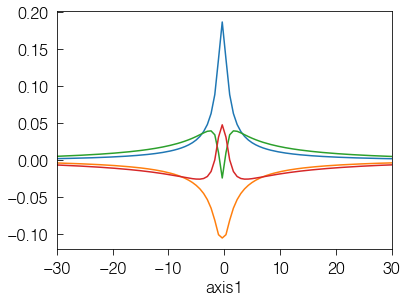

In [96]:
plt.figure()
exc=Tip(0,0)[0]
exc.real.cslice[:,0].plot()
exc=Tip(0,0)[1]
exc.real.cslice[:,0].plot()
exc=Tip(0,0)[2]
exc.real.cslice[:,0].plot()
exc=Tip(0,0)[3]
exc.real.cslice[:,0].plot()
plt.xlim(-30,30)

Text(0.5, 1.0, 'Response)')

<Figure size 432x288 with 0 Axes>

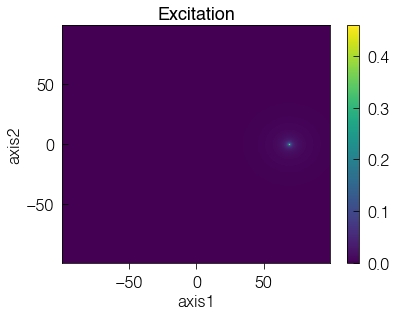

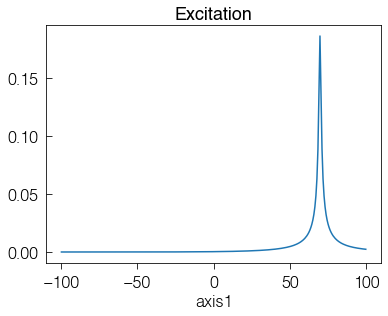

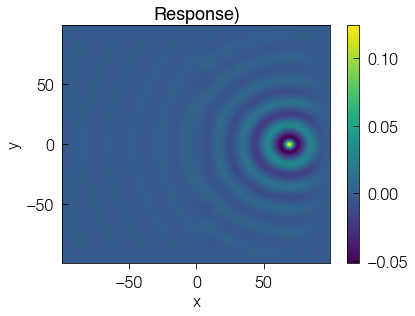

In [97]:
plt.figure()
PS.set_PML_amplitude(1)
PS.set_Sigma2D(0,0*(1-1j/Q))
PS.set_Sigma2D(1,1*(3-1j/Q)) #Defect sigma_x
PS.set_Sigma2D(2,1*(3-1j/Q)) #Defect sigma_x
PS.set_LambdaP(20)
#PS(excitation(X-70,Y)).real.plot()

plt.figure()
exc=Tip(70,0)[0]
exc.real.plot()
plt.title('Excitation')

plt.figure()
exc.real.cslice[:,0].plot()
plt.title('Excitation')

plt.figure()
PS(exc).real.plot()
plt.title('Response)')

# Linescans across domain wall

## Linescan at fixed plasmon wavelength

Working on eigenoscillation index 1...
Projecting excitations...
	Time elapsed: 10.476302862167358
Computing reflection matrix...
	Time elapsed: 10.755522966384888
Computing reflection coefficient
Working on eigenoscillation index 2...
Projecting excitations...
	Time elapsed: 13.4963960647583
Computing reflection coefficient
Working on eigenoscillation index 3...
Projecting excitations...
	Time elapsed: 13.109213829040527
Computing reflection coefficient
Working on eigenoscillation index 4...
Projecting excitations...
	Time elapsed: 13.747061014175415
Computing reflection coefficient
Working on eigenoscillation index 5...
Projecting excitations...
	Time elapsed: 14.341131687164307
Computing reflection coefficient


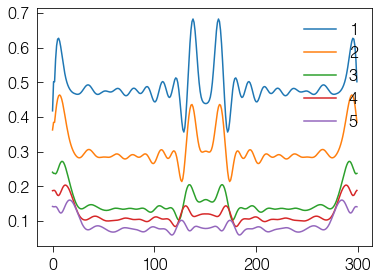

In [98]:
PS.set_PML_amplitude(.1)

plt.figure()
cached_Rmat=False
for eigenosc_index in [0,1,2,3,4]:
    print('Working on eigenoscillation index %i...'%(eigenosc_index+1))
    
    excs=[Tip(x0,0)[eigenosc_index] for x0 in PS.xy[0]]
    Rs=PS.R(excs,exclude_PML=False,cached_Rmat=cached_Rmat)
    cached_Rmat=True
    
    plt.plot(np.abs(Rs),label=eigenosc_index+1)

plt.legend()

## Linescans sweeping lossless $\sigma_{xx}=\sigma_{yy}$

In [100]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

dsigmas=np.linspace(0,3,50)
excs=[Tip(x0,0)[0] for x0 in x0s]
vE=PS.vectors_from(excs)

plt.figure()
linescans1=[]
for dsigma in dsigmas:
    print('Working on dsigma %1.2f...'%dsigma)
    
    dsigma_xx=dsigma_yy=dsigma
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans1.append(Rs)

linescans1=AWA(linescans1,axes=[dsigmas,x0s],axis_names=[r'$\delta\sigma$','$x_0$'])

Working on dsigma 0.00...
Working on dsigma 0.06...
Working on dsigma 0.12...
Working on dsigma 0.18...
Working on dsigma 0.24...
Working on dsigma 0.31...
Working on dsigma 0.37...
Working on dsigma 0.43...
Working on dsigma 0.49...
Working on dsigma 0.55...
Working on dsigma 0.61...
Working on dsigma 0.67...
Working on dsigma 0.73...
Working on dsigma 0.80...
Working on dsigma 0.86...
Working on dsigma 0.92...
Working on dsigma 0.98...
Working on dsigma 1.04...
Working on dsigma 1.10...
Working on dsigma 1.16...
Working on dsigma 1.22...
Working on dsigma 1.29...
Working on dsigma 1.35...
Working on dsigma 1.41...
Working on dsigma 1.47...
Working on dsigma 1.53...
Working on dsigma 1.59...
Working on dsigma 1.65...
Working on dsigma 1.71...
Working on dsigma 1.78...
Working on dsigma 1.84...
Working on dsigma 1.90...
Working on dsigma 1.96...
Working on dsigma 2.02...
Working on dsigma 2.08...
Working on dsigma 2.14...
Working on dsigma 2.20...
Working on dsigma 2.27...
Working on d

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

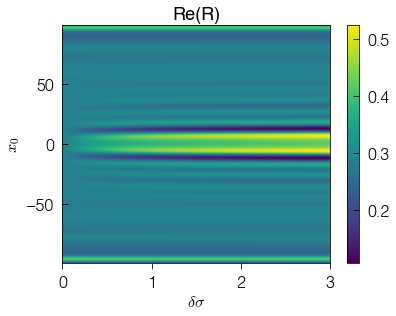

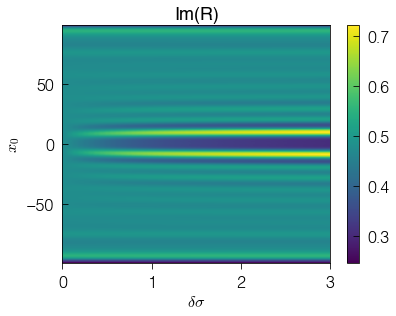

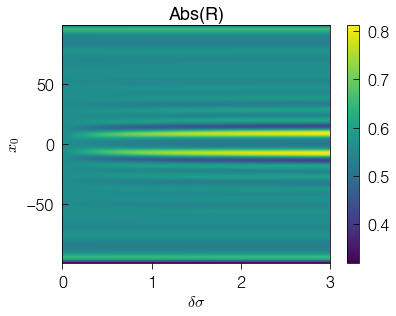

In [101]:
plt.figure()
linescans1.real.plot()
plt.title('Re(R)')

plt.figure()
linescans1.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans1).plot()
plt.title('Abs(R)')

In [111]:
linescans=linescans1
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    dsigma=linescans.axes[0][i]
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title('Re(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title('Im(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title('Abs(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', max=49), Output()), _dom_c…

<function __main__.<lambda>(i)>

## Linescans sweeping lossy $\sigma_{xx}=\sigma_{yy}$

In [100]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

dsigmas=np.linspace(0,3,50)
excs=[Tip(x0,0)[0] for x0 in x0s]
vE=PS.vectors_from(excs)

plt.figure()
linescans2=[]
for dsigma in dsigmas:
    print('Working on dsigma %1.2f...'%dsigma)
    
    dsigma_xx=dsigma_yy=-1j*dsigma
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans2.append(Rs)

linescans2=AWA(linescans2,axes=[dsigmas,x0s],axis_names=[r'$\delta\sigma$','$x_0$'])

Working on dsigma 0.00...
Working on dsigma 0.06...
Working on dsigma 0.12...
Working on dsigma 0.18...
Working on dsigma 0.24...
Working on dsigma 0.31...
Working on dsigma 0.37...
Working on dsigma 0.43...
Working on dsigma 0.49...
Working on dsigma 0.55...
Working on dsigma 0.61...
Working on dsigma 0.67...
Working on dsigma 0.73...
Working on dsigma 0.80...
Working on dsigma 0.86...
Working on dsigma 0.92...
Working on dsigma 0.98...
Working on dsigma 1.04...
Working on dsigma 1.10...
Working on dsigma 1.16...
Working on dsigma 1.22...
Working on dsigma 1.29...
Working on dsigma 1.35...
Working on dsigma 1.41...
Working on dsigma 1.47...
Working on dsigma 1.53...
Working on dsigma 1.59...
Working on dsigma 1.65...
Working on dsigma 1.71...
Working on dsigma 1.78...
Working on dsigma 1.84...
Working on dsigma 1.90...
Working on dsigma 1.96...
Working on dsigma 2.02...
Working on dsigma 2.08...
Working on dsigma 2.14...
Working on dsigma 2.20...
Working on dsigma 2.27...
Working on d

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

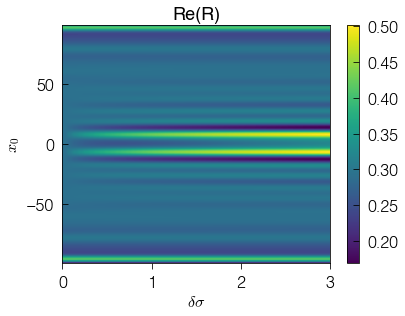

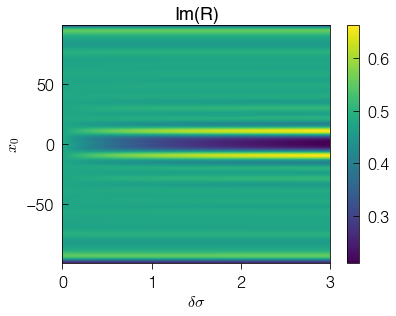

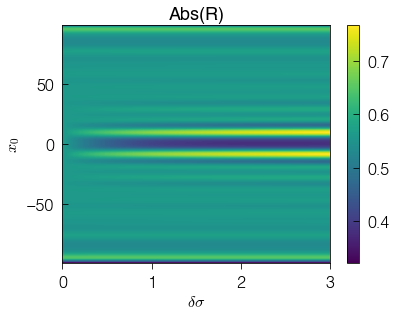

In [113]:
plt.figure()
linescans2.real.plot()
plt.title('Re(R)')

plt.figure()
linescans2.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans2).plot()
plt.title('Abs(R)')

In [114]:
linescans=linescans2
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    dsigma=linescans.axes[0][i]
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title('Re(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title('Im(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title('Abs(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', max=49), Output()), _dom_c…

<function __main__.<lambda>(i)>

## Linescans sweeping the angle $\sigma_{xx}/\sigma_{yy}$

In [121]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

angles=np.linspace(0,np.pi/2,10)
dsigma0=2
#excs=[Tip(x0,0)[0] for x0 in x0s]
#vE=PS.vectors_from(excs)

plt.figure()
linescans3=[]
for angle in angles:
    print('Working on angle %1.2f...'%angle)
    
    dsigma_xx=dsigma0*np.cos(angle)
    dsigma_yy=dsigma0*np.sin(angle)
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans3.append(Rs)

linescans3=AWA(linescans3,axes=[angles,x0s],axis_names=[r'$\theta_{xy}$','$x_0$'])

Working on angle 0.00...
Working on angle 0.17...
Working on angle 0.35...
Working on angle 0.52...
Working on angle 0.70...
Working on angle 0.87...
Working on angle 1.05...
Working on angle 1.22...
Working on angle 1.40...
Working on angle 1.57...


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

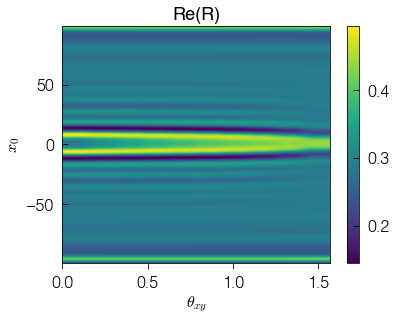

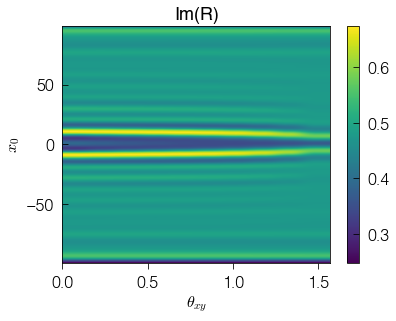

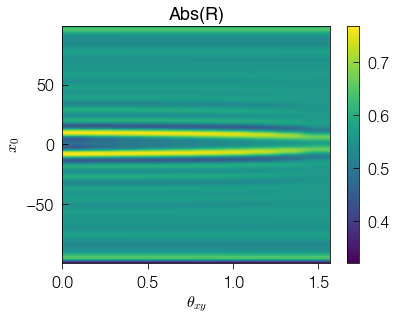

In [122]:
plt.figure()
linescans3.real.plot()
plt.title('Re(R)')

plt.figure()
linescans3.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans3).plot()
plt.title('Abs(R)')

In [156]:
linescans=linescans3
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    angle=linescans.axes[0][i]*180/np.pi
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title(r'Re(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title(r'Im(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title(r'Abs(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=9, continuous_update=False, description='i', max=9), Output()), _dom_cla…

<function __main__.<lambda>(i)>

# Update the domain wall shape and linescan again

(-10.0, 10.0)

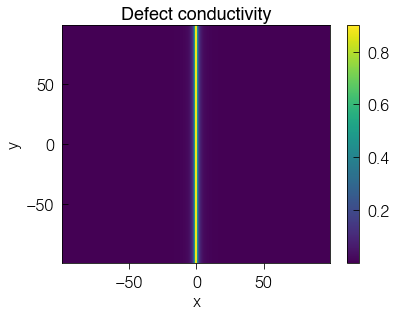

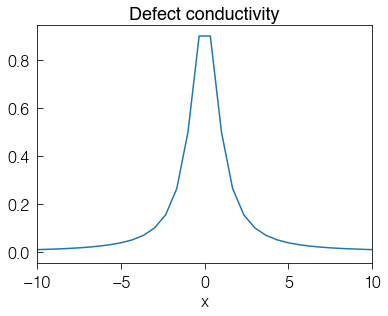

In [155]:
#--- Build inhomogeneous conductivity
width=1
dsigma_profile=width**2/(X**2+width**2)

Defect_xx=TM.S.GridLaplacian_aperiodic(dx,sigma_xx=dsigma_profile,sigma_yy=0) #`sigma` plays role of conductivity
Defect_yy=TM.S.GridLaplacian_aperiodic(dx,sigma_yy=dsigma_profile,sigma_xx=0) #`sigma` plays role of conductivity
#GL=0 #in case we want to turn it off

dsigma_profile=AWA(dsigma_profile,adopt_axes_from=Graphene.AWA)

plt.figure()
dsigma_profile.real.plot()
plt.title('Defect conductivity')

plt.figure()
dsigma_profile.real.cslice[:,0].plot()
plt.title('Defect conductivity')
plt.xlim(-10,10)

In [128]:
#--- Replace existing defect conductivities with the new ones
PS._operator_matrices[-2]=TM.S.NormalMatrix(Defect_xx.as_matrix_in(PS))
PS._operator_matrices[-1]=TM.S.NormalMatrix(Defect_yy.as_matrix_in(PS))

Computing aperiodic Laplacian...
	Time elapsed: 13.482073068618774
Building 2876x2876 inner product matrix...
	Time elapsed: 6.725970983505249
Computing aperiodic Laplacian...
	Time elapsed: 15.193642139434814
Building 2876x2876 inner product matrix...
	Time elapsed: 7.263847827911377


## Linescan at fixed plasmon wavelength

Working on eigenoscillation index 1...
Projecting excitations...
	Time elapsed: 13.774245977401733
Computing reflection matrix...
	Time elapsed: 11.469788074493408
Computing reflection coefficient


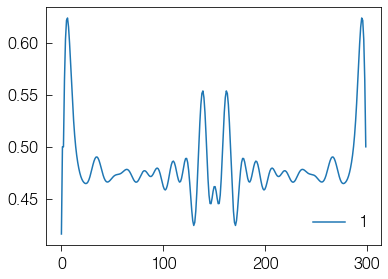

In [134]:
sigma0=0
PS.set_Sigma2D(0,sigma0)
dsigma_xx=dsigma_yy=1
PS.set_Sigma2D(1,dsigma_xx)
PS.set_Sigma2D(2,0)
PS.set_PML_amplitude(0.1)

plt.figure()
cached_Rmat=False
for eigenosc_index in [0]:#,1,2,3,4]:
    print('Working on eigenoscillation index %i...'%(eigenosc_index+1))
    
    excs=[Tip(x0,0)[eigenosc_index] for x0 in PS.xy[0]]
    Rs=PS.R(excs,exclude_PML=False,cached_Rmat=cached_Rmat)
    cached_Rmat=True
    
    plt.plot(np.abs(Rs),label=eigenosc_index+1)

plt.legend()

## Linescans sweeping lossless $\sigma_{xx}=\sigma_{yy}$

In [135]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

dsigmas=np.linspace(0,3,20)
excs=[Tip(x0,0)[0] for x0 in x0s]
vE=PS.vectors_from(excs)

plt.figure()
linescans1=[]
for dsigma in dsigmas:
    print('Working on dsigma %1.2f...'%dsigma)
    
    dsigma_xx=dsigma_yy=dsigma
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans1.append(Rs)

linescans1=AWA(linescans1,axes=[dsigmas,x0s],axis_names=[r'$\delta\sigma$','$x_0$'])

Working on dsigma 0.00...
Working on dsigma 0.06...
Working on dsigma 0.12...
Working on dsigma 0.18...
Working on dsigma 0.24...
Working on dsigma 0.31...
Working on dsigma 0.37...
Working on dsigma 0.43...
Working on dsigma 0.49...
Working on dsigma 0.55...
Working on dsigma 0.61...
Working on dsigma 0.67...
Working on dsigma 0.73...
Working on dsigma 0.80...
Working on dsigma 0.86...
Working on dsigma 0.92...
Working on dsigma 0.98...
Working on dsigma 1.04...
Working on dsigma 1.10...
Working on dsigma 1.16...
Working on dsigma 1.22...
Working on dsigma 1.29...
Working on dsigma 1.35...
Working on dsigma 1.41...
Working on dsigma 1.47...
Working on dsigma 1.53...
Working on dsigma 1.59...
Working on dsigma 1.65...
Working on dsigma 1.71...
Working on dsigma 1.78...
Working on dsigma 1.84...
Working on dsigma 1.90...
Working on dsigma 1.96...
Working on dsigma 2.02...
Working on dsigma 2.08...
Working on dsigma 2.14...
Working on dsigma 2.20...
Working on dsigma 2.27...
Working on d

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

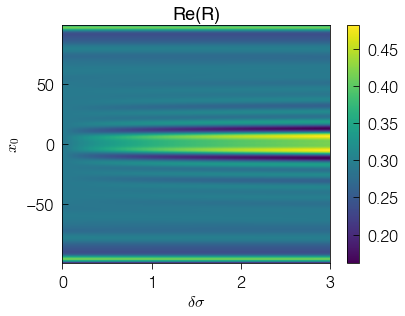

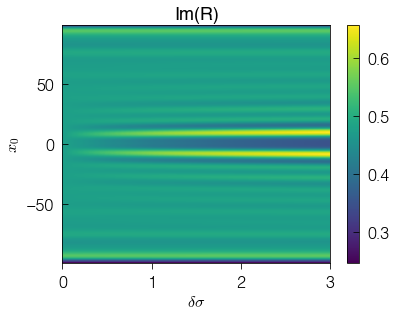

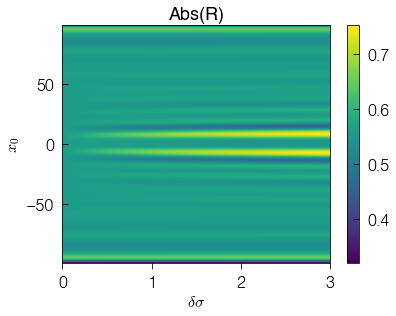

In [144]:
plt.figure()
linescans1.real.plot()
plt.title('Re(R)')

plt.figure()
linescans1.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans1).plot()
plt.title('Abs(R)')

In [153]:
linescans=linescans1
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    dsigma=linescans.axes[0][i]
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title('Re(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title('Im(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title('Abs(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', max=49), Output()), _dom_c…

<function __main__.<lambda>(i)>

## Linescans sweeping lossy $\sigma_{xx}=\sigma_{yy}$

In [146]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

dsigmas=np.linspace(0,3,20)
excs=[Tip(x0,0)[0] for x0 in x0s]
vE=PS.vectors_from(excs)

plt.figure()
linescans2=[]
for dsigma in dsigmas:
    print('Working on dsigma %1.2f...'%dsigma)
    
    dsigma_xx=dsigma_yy=-1j*dsigma
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans2.append(Rs)

linescans2=AWA(linescans2,axes=[dsigmas,x0s],axis_names=[r'$\delta\sigma$','$x_0$'])

Working on dsigma 0.00...
Working on dsigma 0.16...
Working on dsigma 0.32...
Working on dsigma 0.47...
Working on dsigma 0.63...
Working on dsigma 0.79...
Working on dsigma 0.95...
Working on dsigma 1.11...
Working on dsigma 1.26...
Working on dsigma 1.42...
Working on dsigma 1.58...
Working on dsigma 1.74...
Working on dsigma 1.89...
Working on dsigma 2.05...
Working on dsigma 2.21...
Working on dsigma 2.37...
Working on dsigma 2.53...
Working on dsigma 2.68...
Working on dsigma 2.84...
Working on dsigma 3.00...


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

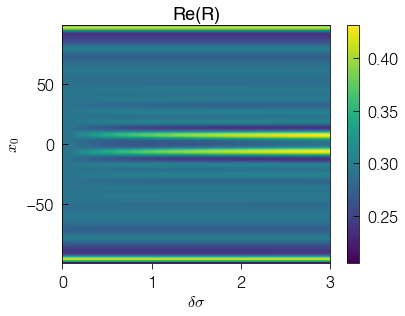

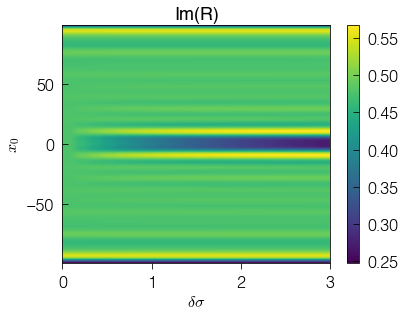

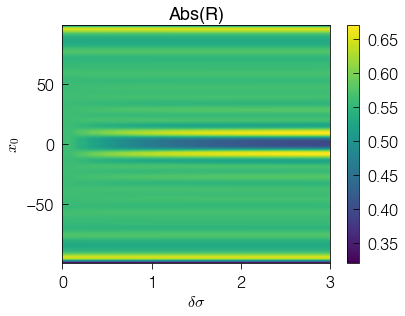

In [147]:
plt.figure()
linescans2.real.plot()
plt.title('Re(R)')

plt.figure()
linescans2.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans2).plot()
plt.title('Abs(R)')

In [148]:
linescans=linescans2
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    dsigma=linescans.axes[0][i]
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title('Re(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title('Im(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title('Abs(R): $\delta \sigma=%1.2f$'%dsigma)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=19, continuous_update=False, description='i', max=19), Output()), _dom_c…

<function __main__.<lambda>(i)>

## Linescans sweeping the angle $\sigma_{xx}/\sigma_{yy}$

In [149]:
sigma_uniform=0
PS.set_Sigma2D(0,sigma_uniform) #Turn off the homogeneous conductivity
PS.set_PML_amplitude(.1)
x0s=PS.xy[0]

angles=np.linspace(0,np.pi/2,10)
dsigma0=2
#excs=[Tip(x0,0)[0] for x0 in x0s]
#vE=PS.vectors_from(excs)

plt.figure()
linescans3=[]
for angle in angles:
    print('Working on angle %1.2f...'%angle)
    
    dsigma_xx=dsigma0*np.cos(angle)
    dsigma_yy=dsigma0*np.sin(angle)
    PS.set_Sigma2D(1,dsigma_xx)
    PS.set_Sigma2D(2,dsigma_yy)
    
    Rs=np.diag(vE.T @ PS.matrix @ vE)
    
    linescans3.append(Rs)

linescans3=AWA(linescans3,axes=[angles,x0s],axis_names=[r'$\theta_{xy}$','$x_0$'])

Working on angle 0.00...
Working on angle 0.17...
Working on angle 0.35...
Working on angle 0.52...
Working on angle 0.70...
Working on angle 0.87...
Working on angle 1.05...
Working on angle 1.22...
Working on angle 1.40...
Working on angle 1.57...


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Abs(R)')

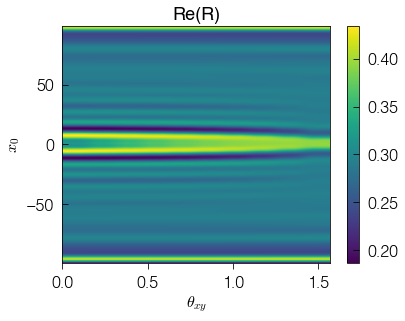

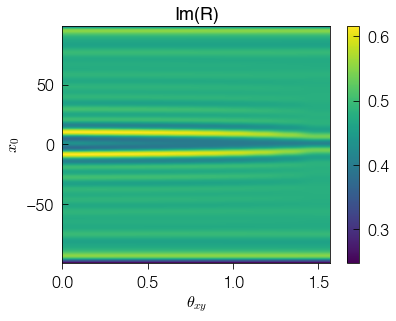

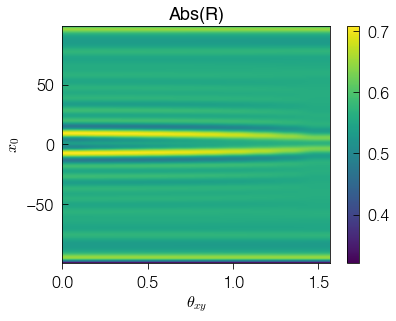

In [150]:
plt.figure()
linescans3.real.plot()
plt.title('Re(R)')

plt.figure()
linescans3.imag.plot()
plt.title('Im(R)')

plt.figure()
np.abs(linescans3).plot()
plt.title('Abs(R)')

In [152]:
linescans=linescans3
w_PML=40*dx

def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i]
    angle=linescans.axes[0][i]*180/np.pi
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title(r'Re(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims1)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title(r'Im(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title(r'Abs(R): $\theta_{xy}=%1.2f^\circ$'%angle)
    plt.ylim(*ylims2)
    plt.xlim(-(L/2-w_PML*1.2),(L/2-1.2*w_PML))
    return

slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(0,1),(0,1.4))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=9, continuous_update=False, description='i', max=9), Output()), _dom_cla…

<function __main__.<lambda>(i)>